In [1]:
import warnings;
warnings.filterwarnings('ignore');

from time import sleep
from tqdm.auto import tqdm

import sys
import importlib
import numpy as np
import nbformat
import pandas as pd
import cvxpy as cp
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import seaborn as sns
import helper
import algorithms


In [12]:
num_iterations = 5

DEBUG = False

file_name = 'uniform_dperish'

# order_list = ['mean', 'cv', 'lcb', 'ucb', 'random', 'flipped']
order_list = ['mean', 'cv', 'lcb', 'ucb']
# order_list = ['mean']
# order_list = ['mean']
# order_list = ['mean']

# problems = ['A', 'B', 'C', 'D', 'E']
# problems = ['A', 'B', 'C']
problems = ['A']


mean_size = 2
var_size = 0

# num_groups = np.arange(10, 155, 20)
# num_groups = [10, 50, 100, 150]
num_groups = [50]
# num_groups = [4]

# alpha_grid = np.arange(0.1,1+0.1, 0.25)
alpha_grid = [0.3]

EPS = 2

In [13]:
def demand_dist(n, mean_size, var_size=.1):
    size = np.maximum(0, np.random.normal(loc=mean_size, scale=np.sqrt(var_size), size=n))
    return size

In [14]:
data = []


# Just defining some baseline variables so that when I "overwrite" them later in the if statements I can use them
# in the rest of the code

def perish_dist(b,n):
    print('test')
    return 0
order = []



for alpha in alpha_grid:
    for n in num_groups:
        for setup in problems:
            OE_FLAG = False
            EPS = 1
            print(f"Problem: {setup}, N: {n}, Alpha: {alpha}")
            max_budget = mean_size*n

            if setup == 'A':
                def perish_dist(b, n):
                    if b < (mean_size*n / 2):
                        low_range = n/2 - (b / mean_size)
                        up_range = n/2 + (b / mean_size)
                    else:
                        low_range = n
                        up_range = n
                    # print(mean, stdev)
                    val = np.ceil(np.maximum(0, np.minimum(n, np.random.uniform(low_range, up_range))))
                    return val
                
                low_range = np.asarray([n/2 - (b / mean_size) if b < (mean_size*n / 2) else n for b in range(max_budget)])
                up_range = np.asarray([n/2 + (b / mean_size) if b < (mean_size*n / 2) else n for b in range(max_budget)])
                mean_list = (1/2) * (low_range + up_range)
                stdev_list = np.sqrt((1/12)*(up_range - low_range) ** 2)
                if DEBUG: print(f'Mean list: {mean_list}')
                if DEBUG: print(f"STDev: {stdev_list}")
                CV = stdev_list / mean_list
                if DEBUG: print(f"CV: {CV}")


            elif setup == 'B':
                def perish_dist(b, n):
                    if b < (mean_size*n / 2):
                        low_range = b+1
                        up_range = b+1
                    else:
                        low_range = b+1
                        up_range = n
                    # print(mean, stdev)
                    val = np.ceil(np.maximum(0, np.minimum(n, np.random.uniform(low_range, up_range))))
                    return val
                low_range = np.asarray([b+1 if b < (mean_size*n / 2) else b+1 for b in range(max_budget)])
                up_range = np.asarray([b+1 if b < (mean_size*n / 2) else n for b in range(max_budget)])
                mean_list = (1/2) * (low_range + up_range)
                stdev_list = np.sqrt((1/12)*(up_range - low_range) ** 2)
                if DEBUG: print(f'Mean list: {mean_list}')
                if DEBUG: print(f"STDev: {stdev_list}")
                CV = stdev_list / mean_list
                if DEBUG: print(f"CV: {CV}")


            elif setup == 'C':
                def perish_dist(b, n):
                    if b < (mean_size*n / 2):
                        low_range = n/2
                        up_range = n/2
                    else:
                        if b < (3 * mean_size*n / 4):
                            low_range = n/2 - 1
                            up_range = n
                        else:
                            low_range = n
                            up_range = n
                    # print(mean, stdev)
                    val = np.ceil(np.maximum(0, np.minimum(n, np.random.uniform(low_range, up_range))))
                    return val
                low_range = np.asarray([n/2 if b < (mean_size*n / 2) else  (n/2 - 1 if b < (3*mean_size * n / 4) else n) for b in range(max_budget)])
                up_range = np.asarray([n/2 if b < (mean_size*n / 2) else n for b in range(max_budget)])
                mean_list = (1/2) * (low_range + up_range)
                stdev_list = np.sqrt((1/12)*(up_range - low_range) ** 2)
                if DEBUG: print(f'Mean list: {mean_list}')
                if DEBUG: print(f"STDev: {stdev_list}")
                CV = stdev_list / mean_list
                if DEBUG: print(f"CV: {CV}")

            offset_prob = helper.check_offset_expiry(perish_dist, lambda n: demand_dist(n, mean_size, var_size), n, max_budget)
            
            print(f'Probability process is offset expiring: {100*offset_prob}')
            # CALCULATES
            n_upper = helper.n_upper(lambda n: demand_dist(n, mean_size, var_size), n)
            x = (mean_size * n) / (mean_size*n + 2 * np.sqrt(var_size * n))
            # x = 0.99999
            if DEBUG: print(f"Estimated B/N: {x}")
            # if DEBUG: print(f"Allocation times: {[int(np.minimum(n, np.ceil((b+1)/(mean_size*x)))) for b in range(max_budget)]}")
            # if DEBUG: print(f"Expiration times: {np.ceil(mean_list)}")
            # if DEBUG: print(f"Differences: {np.asarray([int(np.minimum(n, np.ceil((b+1)/(mean_size*x)))) for b in range(max_budget)]) <= np.ceil(mean_list) }")
            for alloc_order in order_list:
                # print(f"Alloc Order: {alloc_order}")
                for iter in range(num_iterations):
                    # print(f"Iter: {iter}")
                    if alloc_order == 'mean':
                        order = np.lexsort((np.random.random(mean_list.size), mean_list))
                        if DEBUG: print(f"Allocation Order: {alloc_order} and order: {order}")
                    elif alloc_order == 'cv':
                        order = np.lexsort((np.random.random(mean_list.size),(-1)*CV))
                        if DEBUG: print(f"Allocation Order: {alloc_order} and order: {order}")
                    elif alloc_order == 'lcb':
                        order = np.lexsort((np.random.random(mean_list.size),mean_list - 2 * stdev_list))
                        if DEBUG: print(f"Allocation Order: {alloc_order} and order: {order}")

                    elif alloc_order == 'ucb':
                        order = np.lexsort((np.random.random(mean_list.size),mean_list + 2 * stdev_list))
                        if DEBUG: print(f"Allocation Order: {alloc_order} and order: {order}")

                    elif alloc_order == 'random':
                        order = np.random.permutation(max_budget)
                        if DEBUG: print(f"Allocation Order: {alloc_order} and order: {order}")

                    elif alloc_order == 'flipped':
                        order = np.lexsort((np.random.random(mean_list.size),(-1)*mean_list))
                        if DEBUG: print(f"Allocation Order: {alloc_order} and order: {order}")
                    # print(f"Allocation Order: {order}")
                    x_lower_perish = helper.x_lower_line_search(perish_dist, lambda n: demand_dist(n, mean_size, var_size), n, max_budget, n_upper, order)
                    x_lower_no_perish = (max_budget / n_upper[0])

                    dperish = (max_budget / n_upper[0]) - x_lower_perish
                    print(f"Order: {alloc_order}, x_lower_no_perish: {x_lower_no_perish}, x_lower_perish: {x_lower_perish}, dperish: {dperish}")
                    
                    data_dict = {'NumGroups': n, 'Alpha': alpha, 'Epsilon': EPS, 'Problem': setup, 'Order': alloc_order, 'Metric': 'Allocation', 'Value': x_lower_perish}
                    data.append(data_dict)

Problem: A, N: 50, Alpha: 0.3
Probability process is offset expiring: 100.0
Order: mean, x_lower_no_perish: 1.0, x_lower_perish: 0.9099999999999999, dperish: 0.09000000000000008
Order: mean, x_lower_no_perish: 1.0, x_lower_perish: 0.9099999999999999, dperish: 0.09000000000000008
Order: mean, x_lower_no_perish: 1.0, x_lower_perish: 0.9099999999999999, dperish: 0.09000000000000008
Order: mean, x_lower_no_perish: 1.0, x_lower_perish: 0.8999999999999999, dperish: 0.10000000000000009
Order: mean, x_lower_no_perish: 1.0, x_lower_perish: 0.8999999999999999, dperish: 0.10000000000000009
Order: cv, x_lower_no_perish: 1.0, x_lower_perish: 0.94, dperish: 0.06000000000000005
Order: cv, x_lower_no_perish: 1.0, x_lower_perish: 0.9299999999999999, dperish: 0.07000000000000006
Order: cv, x_lower_no_perish: 1.0, x_lower_perish: 0.9299999999999999, dperish: 0.07000000000000006
Order: cv, x_lower_no_perish: 1.0, x_lower_perish: 0.94, dperish: 0.06000000000000005
Order: cv, x_lower_no_perish: 1.0, x_lower

In [ ]:
df = pd.DataFrame.from_records(data)
df.to_csv('./data/'+file_name+'.csv', index=False)


In [ ]:
df_orig = pd.read_csv('./data/'+file_name+'.csv')
problem = 'C'
df_orig = df_orig[(df_orig['Problem'] == problem) & (df_orig['Metric'] == 'Allocation')]


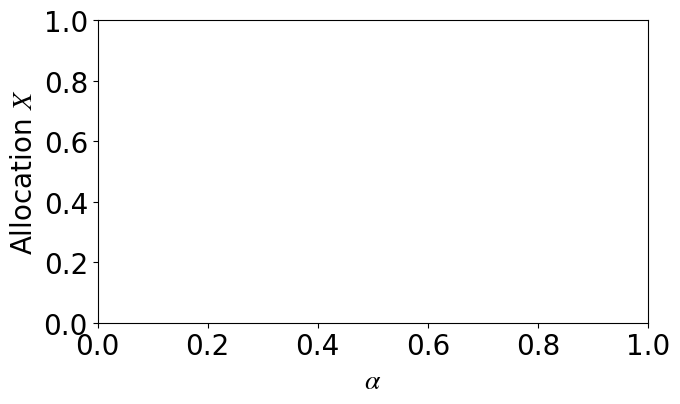

In [ ]:
eps_val = 0.1

df = df_orig[df_orig['NumGroups'] == df_orig['NumGroups'].max()]

plt.style.use('PaperDoubleFig.mplstyle.txt')
plt.rc('text.latex', preamble=r'\usepackage{amsfonts}')

# Make some style choices for plotting 
sns.lineplot(x='Alpha', y='Value', hue = 'Order', data=df, linewidth=2, 
            ci = None)
# plt.axhline(y=x_lower_no_perish, color='k', linestyle='--')


axs = plt.gca()

# axs.get_legend().remove() 
axs.set_ylabel(r'Allocation $X$')
axs.set_xlabel(r'$\alpha$')

# plt.savefig('./figures/'+file_name+'.pdf', bbox_inches = 'tight',pad_inches = 0.01, dpi=900)
plt.show()

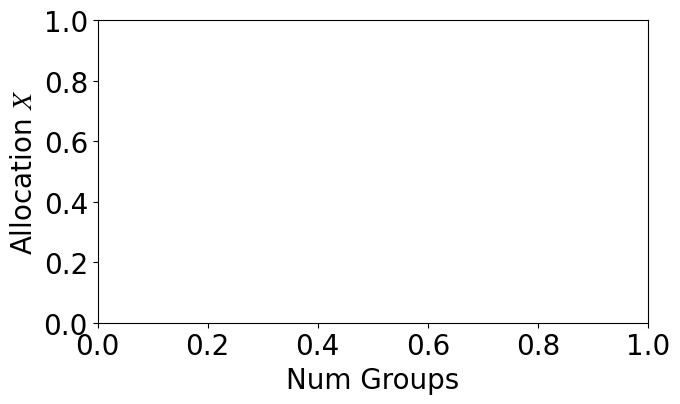

In [ ]:
alpha_val = 0.3

df = df_orig[df_orig['Alpha'] == alpha_val]

plt.style.use('PaperDoubleFig.mplstyle.txt')
plt.rc('text.latex', preamble=r'\usepackage{amsfonts}')

# Make some style choices for plotting 
sns.lineplot(x='NumGroups', y='Value', hue = 'Order', data=df, linewidth=2, 
            ci = None)
# plt.axhline(y=x_lower_no_perish, color='k', linestyle='--')


axs = plt.gca()

# axs.get_legend().remove() 
axs.set_ylabel(r'Allocation $X$')
axs.set_xlabel(r'Num Groups')

# plt.savefig('./figures/'+file_name+'.pdf', bbox_inches = 'tight',pad_inches = 0.01, dpi=900)
plt.show()
